In [ ]:
import os, time, base64, math
from typing import List, Dict, Tuple
from dotenv import load_dotenv
from openai import OpenAI
import numpy as np
from PIL import Image
from IPython.display import display

# --------- 0a) 기본 설정 ---------
from openai import OpenAI

load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

if not OPENAI_API_KEY:
    raise ValueError("OPENAI_API_KEY가 설정되어 있지 않습니다.")

client = OpenAI()

# ============ 예시 사용 ============
response = client.chat.completions.create(
    model="gpt-4.1-mini",   # 원하면 gpt-4.1, gpt-4o-mini 등으로 변경 가능
    messages=[{"role": "user", "content": "너는 어떤 모델인지 간단하게 답변해줘"}]
)

print(response.choices[0].message.content)

저는 OpenAI가 만든 GPT-4 기반의 언어 모델입니다. 질문에 답하거나 대화를 돕는 역할을 합니다.


=== Query ===
블랙베리 

=== Results ===
[Top-1] 05.jpg  (similarity=0.4425)
  caption: 블랙베리 스마트폰이 손에 들려 있다.


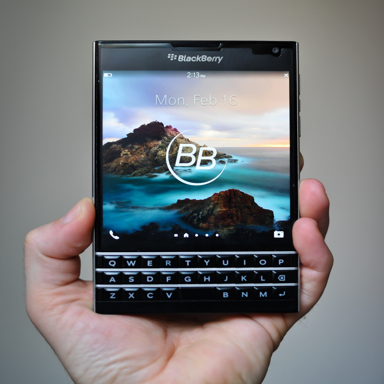

[Top-2] 06.jpg  (similarity=0.3764)
  caption: 블랙베리 스마트폰, 물리적 키패드가 특징인 디자인입니다.


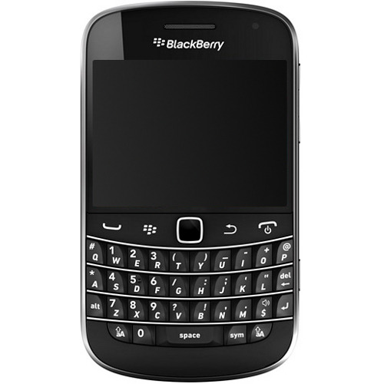

[Top-3] 01.jpg  (similarity=0.2297)
  caption: 아이폰과 화이트 배터리 케이스가 나란히 있다.


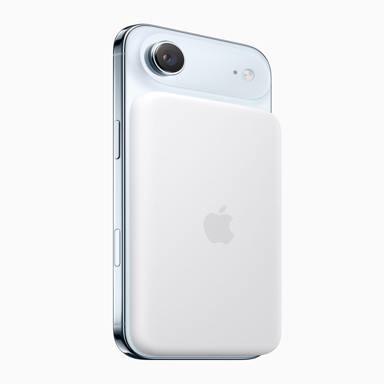

In [2]:
# --------- 0b) 추가 세팅  ---------
IMAGE_DIR = "img"
IMAGE_FILES = ["01.jpg", "02.jpg", "03.jpg", "04.jpeg", "05.jpg", "06.jpg"]  # 필요시 확장 가능
VISION_MODEL = "gpt-4o-mini"        # caption용
EMB_MODEL = "text-embedding-3-small"  # 임베딩용 (속도/비용 우선)
TOP_K = 3                           # 상위 k개 반환 (1로 줄이면 Top-1만)

# --------- 1) 유틸 ---------
def to_data_url(path: str) -> str:
    with open(path, "rb") as f:
        b64 = base64.b64encode(f.read()).decode("utf-8")
    ext = path.split(".")[-1].lower()
    mime = "image/jpeg" if ext in ["jpg", "jpeg"] else "image/png"
    return f"data:{mime};base64,{b64}"

def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
    # a, b: (D,)
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    return float(a.dot(b) / denom) if denom else 0.0

def embed_texts(texts: List[str]) -> np.ndarray:
    resp = client.embeddings.create(model=EMB_MODEL, input=texts)
    vecs = [d.embedding for d in resp.data]
    # L2 normalize (코사인 유사도 안정화 & 속도)
    vecs = np.array(vecs, dtype=np.float32)
    norms = np.linalg.norm(vecs, axis=1, keepdims=True)
    norms[norms == 0] = 1.0
    return vecs / norms

def caption_image(path: str, system_prompt: str = None) -> str:
    """
    Vision 모델로 간결하고 검색 친화적인 캡션 생성
    """
    data_url = to_data_url(path)
    messages = [
        {"role":"system","content": system_prompt or
         "You are a helpful vision assistant. Write a single short caption (<= 20 tokens) in Korean with concrete nouns."},
        {"role":"user","content":[
            {"type":"text","text":"이 이미지를 한 문장으로 간결하게 묘사해 주세요."},
            {"type":"image_url","image_url":{"url":data_url}}  # 여기가 수정된 부분
        ]}
    ]
    r = client.chat.completions.create(model=VISION_MODEL, messages=messages)
    return r.choices[0].message.content.strip()

def show_results(results: List[Tuple[str, float, str]], k: int = 3):
    """
    results: [(file, score, caption), ...] 유사도 내림차순
    """
    k = min(k, len(results))
    for rank in range(k):
        f, s, c = results[rank]
        print(f"[Top-{rank+1}] {f}  (similarity={s:.4f})")
        print(f"  caption: {c}")
        try:
            display(Image.open(os.path.join(IMAGE_DIR, f)).resize((384, 384)))
        except Exception:
            pass

# --------- 2) 인덱싱(캡션 → 임베딩) ---------
# 캡션 생성 (필요 시 한 번씩만 실행, 여기서는 매번 생성해도 되도록 최소화)
images: List[Dict] = []
for fname in IMAGE_FILES:
    path = os.path.join(IMAGE_DIR, fname)
    if not os.path.exists(path):
        print(f"경고: 파일 없음 - {path}")
        continue
    cap = caption_image(path)
    images.append({"file": fname, "caption": cap})

if not images:
    raise RuntimeError("검색할 이미지가 없습니다.")

# 캡션 임베딩
caption_texts = [d["caption"] for d in images]
caption_embs = embed_texts(caption_texts)  # shape: (N, D)

# --------- 3) 검색 함수 ---------
def search_images(query: str, top_k: int = TOP_K) -> List[Tuple[str, float, str]]:
    q_vec = embed_texts([query])[0]  # (D,)
    # caption_embs는 이미 정규화됨 → q_vec도 정규화됨 → 내적이 코사인유사도
    sims = caption_embs @ q_vec
    order = np.argsort(-sims)  # 내림차순
    results = []
    for idx in order[:top_k]:
        results.append((images[idx]["file"], float(sims[idx]), images[idx]["caption"]))
    return results

# --------- 4) 예시 실행 ---------
# 사용자 입력 받기
example_query = input("검색하고 싶은 이미지를 설명해주세요: ")
results = search_images(example_query, top_k=TOP_K)

print("=== Query ===")
print(example_query, "\n")
print("=== Results ===")
show_results(results, k=TOP_K)

이미지 검색을 시작합니다. 'quit' 또는 'exit'를 입력하면 종료됩니다.

=== '삼성' 검색 결과 ===
[Top-1] 03.jpg  (similarity=0.3801)
  caption: 새로운 삼성 스마트폰, 두 개의 카메라와 화면.


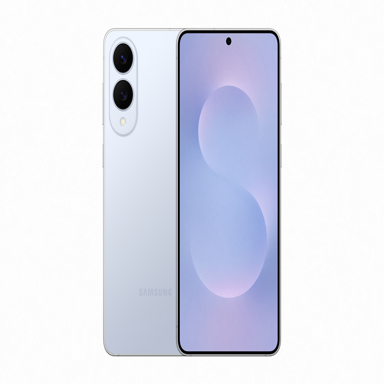

[Top-2] 04.jpeg  (similarity=0.2019)
  caption: 스마트폰과 카메라 렌즈가 있는 테이블 위의 이미지.


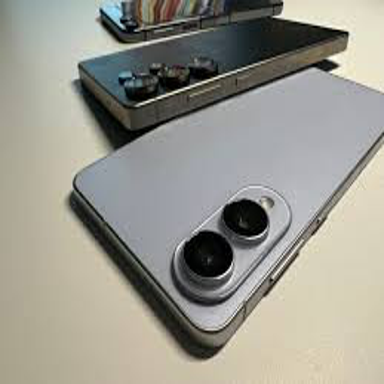

[Top-3] 02.jpg  (similarity=0.1978)
  caption: 아이폰 두 대가 나란히 놓여 있습니다.


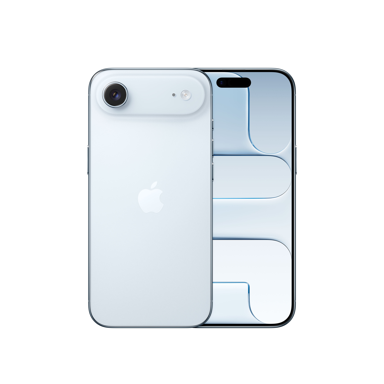

검색을 종료합니다.


In [4]:
# --------- 4) 대화형 검색 ---------
print("이미지 검색을 시작합니다. 'quit' 또는 'exit'를 입력하면 종료됩니다.")
print("=" * 50)

while True:
    example_query = input("\n검색하고 싶은 이미지를 설명해주세요: ").strip()
    
    if example_query.lower() in ['quit', 'exit', '종료', 'q']:
        print("검색을 종료합니다.")
        break
    
    if not example_query:
        print("검색어를 입력해주세요.")
        continue
    
    try:
        results = search_images(example_query, top_k=TOP_K)
        print(f"\n=== '{example_query}' 검색 결과 ===")
        show_results(results, k=TOP_K)
    except Exception as e:
        print(f"검색 중 오류가 발생했습니다: {e}")